# Estrategias para QE

## **Objetivo :**

* Desarrollar una estrategia de representación para textos cortos que capture una mejor representación semántica de los textos y que facilite la tarea de agrupación.

Una de las estrategias evaluadas, para capturar una mejor representación semántica de los textos es usar QE, la figura 1 corresponde al esquema general que se sigue en este tipo de procesamiento. En nuestro caso $\mathbf{q}$ representa los diferentes títulos de los proyectos de investigación que se quieren agrupar, el sistema de recuperación de información ($IR$) es google, y como resultado obtenemos $\Omega_{res} = \left\{\mathbf{d}_{1}, \ldots, \mathbf{d}_{N} \right\}$.Dado este conjunto de resultado Google hace juzgamiento de la relevancia de los documentos (F), obteniendo un conjunto de documentos relevantes para la query $\Omega_{fback} = \left\{\mathbf{d}_{1}, \ldots, \mathbf{d}_{M} \right\}$ con $\Omega_{fback} \subseteq \Omega_{res}$. En nuestro caso usamos los primeros 30 resultados "mas" relevantes de cada consulta. Los elementos que son guardados para documento relevante son:<br>

* **Google_url**: la url que direcciona al documento relevante.
* **Description**: es un texto corto con la descripción de la página que ha sido seleccionada.

Partiendo del conjunto de resultados relevantes para cada documento, se hace la selección de palabras ($FE$), de este esquema resulta $\mathbf{g}$ el cual es un conjunto de términos que servirá para tener una mejor representación semántica de los textos analizados.

![Image of QE model](https://lisi1.unal.edu.co/user/jmcarrascoo/files/Src/Images_DOC/squemaQE.png)

#### Lectura de busqueda en Scopus

In [ ]:
from searchScopus import scopusResult, searchScopus, searchSciense
import pickle, collections, sPickle, numpy as np

outPath = '../Output/'  # Definir directorios

# # Lectura de resultados (Omega_res)
allDoc = []
datUN = pickle.load(open(outPath + 'datosFinal_RE.pkl', 'rb')) 
indUN = np.unique(datUN[datUN['IND_PROYECTO'] != 0].loc[:, 'Indice_Busqueda']) # Indices

for key, element in sPickle.s_load(open(outPath + 'query_data_sc_RE.spkl')):
    if (key in indUN):# # Exclusion IND_PROYECTO
        exq       = element.response
        documents = [ww.tile + ww.abstract for ww in exq if not ww.abstract is None]    
        allDoc.extend(documents)
    
print(len(allDoc))

In [2]:
datUN[datUN['Indice_Busqueda'] == 470]

,CODIGO_EMPRESA,SEDE,NOMBRE_EMPRESA,verifica,CODIGO_QUIPU,TIPO_PROYECTO,DESCRIPCION_PROYECTO,IND_PROYECTO,IND_INGLES,NIT_EMPRESA_EXTERNA,...,PROY_FECH,ORIGEN_EMPRESA_EXTERNA,AÑO SUSCRIPCION,SUSCRIPCION,DESCRIPCION_PROYECTO_RE,INDIOMA_nltk,NEW_DESCRIPCION_PROYECTO,NEW_DESCRIPCION_PROYECTO_IN,SIN_PUNTUACION,Indice_Busqueda
597,3065,MEDELLIN,UGI FACULTAD DE MINAS MEDELLIN,1,20201009460,Proyecto de Investigacion,UTILIZACIÓN DE LA LIGNINA PREVIAMENTE DESPOLIM...,1,0,899999296,...,NaN,NACIONAL,2011,Suscrito,UTILIZACIÓN DE LA LIGNINA PREVIAMENTE DESPOLIM...,spanish,UTILIZACIÓN DE LA LIGNINA PREVIAMENTE DESPOLIM...,Use of lignin depolymerized PREVIOUSLY FOR OBT...,use of lignin depolymerized previously for obt...,470


#### Distributional terms representation (DTR)

Se utilizaron DTR, como son representación basada en ocurrencia de documentos (document ocurrence representation, DOR) y la representación basada en co-ocurrencias entre términos (term coocurrence representation, TCOR):

* **Representación basada en ocurrencia de documentos (DOR)**: Se basa en la idea de que los términos que componen los documentos puede ser representados semánticamente por los documentos en los que aparece, el interés es encontrar $\vec{w_{j}} = <w_{j1}, \ldots, w_{jN}> \in R^{N}$, siendo $N$ el número de documentos recuperados y $ w_{jk} \in [0, 1]$ es la contribución del documento $k$-esimo a la semántica del texto $j$.

\begin{align*}
        A´  &= (1 + log(A^{T})) \\
        D   &= diag \left(\frac{|T|}{\pi(d_{1})}, \ldots, \frac{|T|}{\pi(d_{N})}\right)  \\
        DOR &= A´D \\
\end{align*}      

En donde $A_{ij} = df(d_{j}, t_{i})$, $\pi(d_{k})$ es el numero de términos diferentes en el diccionario $T$ de los documentos recuperados que aparecen en el documento $d_{k}$, es decir $\pi(d_{k}) = \left|\left\{t_{i} \,\,| \,\, t_{i} \in d_{k} \land t_{i} \in T \right\}\right|$.


* **Representación basada en co-ocurrencia de términos (TCOR)**: Esta medida tiene que ver con la idea de que la semántica de un término $t_{j}$ puede ser representada por otros términos que pertenecen al vocabulario de la colección, en este caso se quiere encontrar $\vec{w_{j}} = <w_{j1}, \ldots, w_{j|T|}> \in R^{|T|}$, tal que $t_{j} \in T$, es decir   y $ w_{jk} \in [0, 1]$ es la contribución del documento $k$-esimo a la semántica del texto $j$.

\begin{align*}
        B^{'} &= (1 + log(B^{t} * B)) \\
        D     &= diag \left(\frac{|T|}{\gamma(t_{1})}, \ldots, \frac{|T|}{\gamma(t_{|T|})}\right)  \\
        TCOR  &= DB^{'}        
\end{align*}      

En donde $B_{ij} =   \left \{ \begin{matrix} 1 & \mbox{si   }t_{j} \in d_{i}
\\ 0 &\mbox{e.o.c}\end{matrix}\right. $, $\gamma(t_{j})$ es el numero de diferente términos en el diccionario $T$ que co-ocurren con $t_{j}$ en al menos un documento.

In [3]:
import pandas as pd
import numpy as np
import nltk, collections, re, string, scipy, gc, os
from scipy import sparse
from itertools import groupby
from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix, dia_matrix
from nltk.stem.porter import PorterStemmer


#from gensim import corpora, models, similarities, matutils
cachedStopWords = stopwords.words("english")
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def removeStops(text):
     # # Arreglando textos (minuzculas, quitando puntuaciones, asentos, palabras repetidas, duplicados)
     result = ' '.join([word.lower() for word in text.translate(remove_punctuation_map).split() 
                        if word not in cachedStopWords and not any([c.isdigit() for c in word])])
     return(result)

# quitando puntuación  
fileStop = outPath + "query_stop_sc_RE.spkl"
if os.path.exists(fileStop):   
    allDoc_stop = [ww for ww in sPickle.s_load(open(fileStop))]
else:
    allDoc_stop    = [removeStops(ww) for ww in allDoc]
    del allDoc
    gc.collect()    
    sPickle.s_dump(allDoc_stop, open(fileStop, 'w'))
#sin_duplicados = [item for item, count in collections.Counter(allDoc_stop).items() if count >= 1]

class DTR:
    """ Represents a results of DTR"""
    def __init__(self, listDocs, listRemove = []):
    
        stemmer = PorterStemmer()
        def tokenize_and_stem(text):
            #first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
            tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
            filtered_tokens = []
            # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
            for token in tokens:
                if re.search('[a-zA-Z]', token):
                    filtered_tokens.append(token)
            stems = [stemmer.stem(t) for t in filtered_tokens]
            return stems
   
        co_Vectorizer = CountVectorizer(max_df = 0.03, min_df = 0.000005, 
                                        stop_words='english',
                                        tokenizer=tokenize_and_stem)
        self.A = co_Vectorizer.fit_transform(allDoc_stop)
        self.vocabulary = co_Vectorizer.vocabulary_
        print("---- Finish stemming and tokenization\n")
                
    def computeDTR(self):
        # # TCOR matrix
        tcooCur         = self.A      
        tcooCur.data[:] = tcooCur.data / tcooCur.data
        
        # # Found DF for terms
        self.nt = tcooCur.sum(axis=0)  
        
        tcooCur         = tcooCur.T * tcooCur
        tcooCur.data[:] = (1 + np.log(tcooCur.data))
        nor_Row         = np.log(len(self.vocabulary))/ np.bincount(tcooCur.nonzero()[0])
        tcooCur         = dia_matrix((nor_Row, np.array([0])), shape=(len(nor_Row), len(nor_Row))) * tcooCur 
        self.TCOR       = tcooCur
        
        del tcooCur, nor_Row
        gc.collect()
        
        # # DOR matrix
        dcor         = self.A.T
        dcor.data[:] = (1 + np.log(dcor.data))
        nor_Row      = np.log(len(self.vocabulary)) / np.bincount(dcor.nonzero()[1])
        dcor         = dcor * dia_matrix((nor_Row, np.array([0])), shape=(len(nor_Row), len(nor_Row)))
        self.DOR     = dcor
    
    def weightDoc(self, texts, tfs, flagTCOR = True):
        result = []
        for row, text in texts:
            mt_row = tfs.getrow(row)
            index    = [(self.vocabulary.get(ww), mt_row.getcol(tfidf.vocabulary_[ww]).data[0]) for ww in text 
                        if not self.vocabulary.get(ww) is None]
            nrow  = len(index)
            alpha = csr_matrix(([jj for ii, jj in index], (np.repeat(0, nrow), range(nrow))), shape=(1, nrow))
            if flagTCOR:
                result.append(alpha * self.TCOR[np.array([ii for ii, jj in index]), :])
            else:
                result.append(alpha * self.DOR[np.array([ii for ii, jj in index]), :])
                
        return(scipy.sparse.vstack(result))

In [4]:
# # Tiempo en 
import time
start_time = time.time()
removeStops(allDoc_stop[1])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00206685066223 seconds ---


In [5]:
pathDTR = outPath + 'DTR_RE.pickle'
if os.path.exists(pathDTR):
    prueba = pickle.load(open(pathDTR, 'rb'))
    print("--- Load stemming and tokenization\n")
else:
    prueba = DTR(listDocs = allDoc_stop)
    pickle.dump(prueba, open(pathDTR, 'wb'))
prueba.computeDTR()

---- Finish stemming and tokenization



In [6]:
prueba.TCOR

<37069x37069 sparse matrix of type '<type 'numpy.float64'>'
	with 19312815 stored elements in Compressed Sparse Row format>

In [7]:
prueba.DOR

<37069x202792 sparse matrix of type '<type 'numpy.float64'>'
	with 6987672 stored elements in Compressed Sparse Column format>

In [8]:
pd.DataFrame({'DF' : np.array(prueba.nt)[0] / float(len(allDoc_stop)), 
              'N_t': np.array(prueba.nt)[0]}).describe()

,DF,N_t
count,37069.000000,37069.000000
mean,0.000930,188.504465
std,0.003017,611.886599
min,0.000010,2.000000
25%,0.000015,3.000000
50%,0.000030,6.000000
75%,0.000212,43.000000
max,0.029986,6081.000000


In [64]:
sum(prueba.TCOR.getcol(prueba.vocabulary[u'accumul']).toarray() != 0)
ppp = [listaOrden[ww] for ww in np.where(np.array(prueba.nt)[0] / float(len(allDoc_stop)) < 0.000012)[0]]
prueba.vocabulary[ppp[0]]

1

In [83]:
#np.where([ww == u'commonli' for ww in prueba.vocabulary])
#print(np.where(prueba.A.T.getrow(8315).toarray()[0] != 0))
#allDoc_stop[4]
listaOrden = sorted(prueba.vocabulary, key=prueba.vocabulary.__getitem__)

print(len([listaOrden[ww] for ww in np.where(np.array(prueba.nt)[0] / float(len(allDoc_stop)) > 0.028)[0]]))
print(len([listaOrden[ww] for ww in np.where(np.array(prueba.nt)[0] / float(len(allDoc_stop)) < 0.000012)[0]]))

44
8813


In [82]:
[listaOrden[ww] for ww in np.where(np.array(prueba.nt)[0] / float(len(allDoc_stop)) > 0.028)[0]]

[u'abl',
 u'accur',
 u'analyt',
 u'approxim',
 u'connect',
 u'criteria',
 u'degeneration\xa9',
 u'degre',
 u'demand',
 u'efficaci',
 u'expect',
 u'extens',
 u'foundat',
 u'incorpor',
 u'increasingli',
 u'inner',
 u'interview',
 u'larger',
 u'liquid',
 u'maintain',
 u'manipul',
 u'map',
 u'mass',
 u'maximum',
 u'migrat',
 u'moder',
 u'n',
 u'numer',
 u'poor',
 u'preserv',
 u'price',
 u'recommend',
 u'replac',
 u'sector',
 u'simpl',
 u'singl',
 u'strongli',
 u'subsequ',
 u'systemat',
 u'theori',
 u'trend',
 u'uniqu',
 u'usual',
 u'yield']

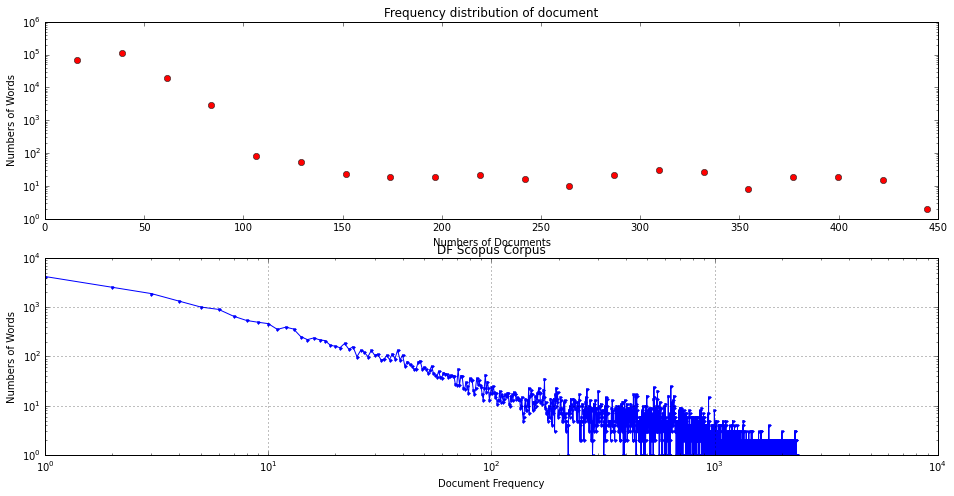

In [84]:
%matplotlib inline
from __future__ import division
from itertools import *
from pylab import *
from matplotlib import pyplot
rcParams['figure.figsize'] = 16, 12

# Histogram of numbers of Words
pyplot.subplot(311)
counts,bin_edges = np.histogram(np.bincount(np.sort(prueba.A.nonzero()[0])), 20)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2.
err = np.random.rand(bin_centres.size) * 100
pyplot.semilogy(bin_centres, counts, 'ro')
title("Frequency distribution of document")
xlabel("Numbers of Documents")
ylabel("Numbers of Words")

# A log-log plot to Document Frequency
pyplot.subplot(312)
freq_DF = collections.Counter(np.array(prueba.nt)[0])
counts  = collections.OrderedDict(sorted(freq_DF.items()))
frequencies = [v for k, v in counts.iteritems()]
ranks       = [k for k, v in counts.iteritems()]
loglog(range(len(frequencies)), frequencies, marker=".")
title("DF Scopus Corpus")
xlabel("Document Frequency")
ylabel("Numbers of Words")
grid(True)

In [85]:
import os
# # Funcion para extraer tokens
def parsetexts(tokens, tfs):
    index  = zip(tfs.nonzero()[0], tfs.nonzero()[1])
    tokens = [(key, [tokens[thing[1]] for thing in group]) for key, group in 
              groupby(index, lambda x: x[0])]
    return(tokens)

# # Lectura de resultados (Omega_res)
datUN = pickle.load(open(outPath + 'datosFinal_RE.pkl', 'rb')) 
indUN = np.unique(datUN[datUN['IND_PROYECTO'] != 0].loc[:, 'Indice_Busqueda']) # Indices

# # Lectura del indice con textos originales
fileIndex = outPath + "indexQyery_RE.pkl"
if os.path.exists(fileIndex): 
    indexQuery = pickle.load(open(fileIndex, 'rb'))
sin_puntuacion = [indexQuery[ww] for ww in indUN]
listDupli      = np.unique([re.sub("\s", "", ww) for ww in sin_puntuacion], return_index = True)
sin_duplicados = np.array(sin_puntuacion)[np.array(listDupli[1])]
sin_duplicados = sin_duplicados[np.where(sin_duplicados != u'')]

def stemText(text):
    return ' '.join([PorterStemmer().stem(word) for word in text.split()])
sin_duplicados = [stemText(ww) for ww in sin_duplicados]

# # Representación del texto
tfidf = TfidfVectorizer(stop_words = cachedStopWords, # tokenizar y eliminar stops word
                        strip_accents='unicode')      # haciendo representación tf - if
tfs   = tfidf.fit_transform(sin_duplicados)           
texts = parsetexts(tfidf.get_feature_names(), tfs)                                  # Construyendo diccionario de terminos
pickle.dump([sin_duplicados, tfs, texts, listDupli[1]], open(outPath + 'tfidforig_RE.pickle', 'wb')) # Guardando resultados
print("---- Representación tf-idf documentos originales Guardada ---")

---- Representación tf-idf documentos originales Guardada ---


In [12]:
# # Document Frequency of terms
sin_duplicados, tfs, texts, listORF = pickle.load(open(outPath + 'tfidforig_RE.pickle', 'rb'))
calDF_Ori = pd.DataFrame({'DF' : [sum(np.array(tfs.T.getrow(ww).toarray()[0]) != 0) / float(tfs.shape[0]) 
                                  for ww in range(tfs.shape[1])] , 
              'N_t': [sum(np.array(tfs.T.getrow(ww).toarray()[0]) != 0) for ww in range(tfs.shape[1])]})
calDF_Ori.describe()

,DF,N_t
count,5658.000000,5658.000000
mean,0.001967,4.205373
std,0.004922,10.524157
min,0.000468,1.000000
25%,0.000468,1.000000
50%,0.000468,1.000000
75%,0.001403,3.000000
max,0.096819,207.000000


In [92]:
print("Dimension tf-idf original:  " + str(tfs.shape) + "\n")
WTCOR = prueba.weightDoc(texts, tfs, flagTCOR = True)
pickle.dump(WTCOR, open(outPath + 'WTCOR_RE.pickle', 'wb'))
WTCOR

Dimension tf-idf original:  (2138, 5639)



<2138x37069 sparse matrix of type '<type 'numpy.float64'>'
	with 21180208 stored elements in Compressed Sparse Row format>

total excluidas:  19
[u'analysi', u'character', u'colombiano', u'colombiens', u'dessert', u'di', u'director', u'effort', u'evid', u'mania', u'modul', u'navig', u'profess', u'program', u'propag', u'respect', u'subsid', u'tambo', u'vaginosi']
---- Representación tf-idf documentos originales Guardada ---


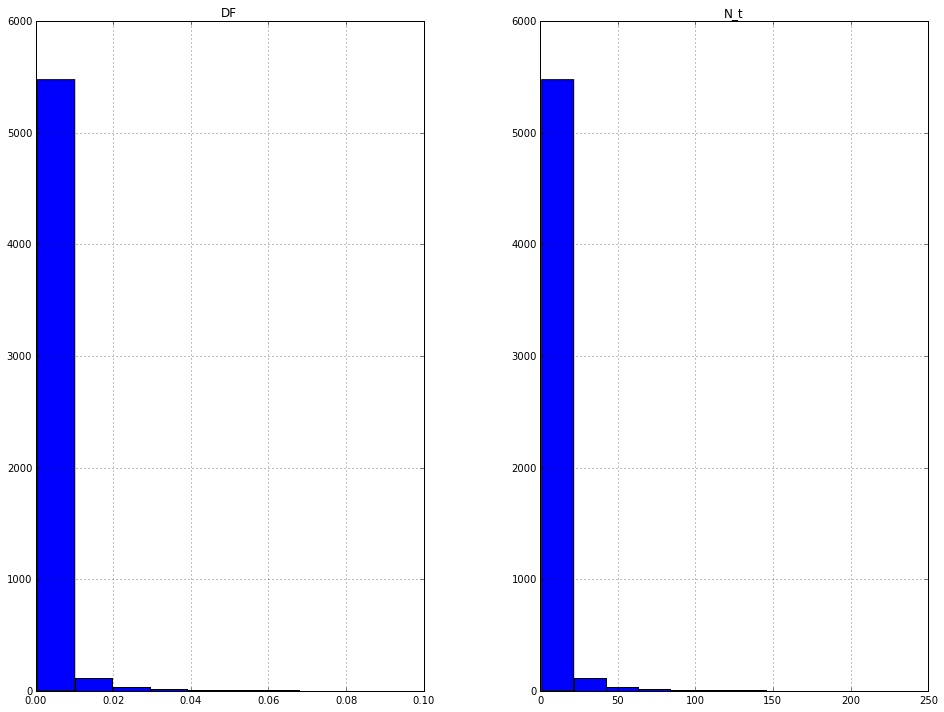

In [90]:
calDF_Ori.hist()
excludWord = [tfidf.get_feature_names()[ww] for ww in np.where(calDF_Ori.DF > 0.04)[0]]
print("total excluidas:  " + str(len(excludWord)))
print(excludWord)

# # Representación del texto
tfidf = TfidfVectorizer(max_df = 0.04, min_df = 0,
                        stop_words = cachedStopWords, # tokenizar y eliminar stops word
                        strip_accents='unicode')      # haciendo representación tf - if
tfs   = tfidf.fit_transform(sin_duplicados)           
texts = parsetexts(tfidf.get_feature_names(), tfs)                                  # Construyendo diccionario de terminos
pickle.dump([sin_duplicados, tfs, texts, listDupli[1]], open(outPath + 'tfidforig_RE.pickle', 'wb')) # Guardando resultados
print("---- Representación tf-idf documentos originales Guardada ---")

In [ ]:
WDOR = prueba.weightDoc(texts, tfs, flagTCOR = False)
pickle.dump(WDOR, open(outPath + 'WDOR_RE.pickle', 'w'))
WDOR

In [93]:
# # Strange Vocabulary 
pKeys     = prueba.vocabulary.keys()
elemnts   = tfidf.get_feature_names()
ind       = [el in pKeys for el in elemnts] 
not_Found = [elemnts[ii] for ii in range(len(elemnts)) if not ind[ii]]

# # Find IDF
countvec = CountVectorizer(binary = True, strip_accents='unicode')
ppp = countvec.fit_transform(sin_duplicados)
nt  = np.array(ppp.sum(axis=0))[0]
IDF = [np.log(len(sin_duplicados) / ii) for ii in nt]
IFM = [np.log(1 + max(nt) / ii) for ii in nt]

nf_NT  = [nt[countvec.vocabulary_[element]] for element in not_Found]
nf_IDF = [IDF[countvec.vocabulary_[element]] for element in not_Found]
nf_IFM = [IFM[countvec.vocabulary_[element]] for element in not_Found]

# # max TF-IDF
tfidf_max = tfs.max(axis = 0).toarray()
nf_TFIDF    = [tfidf_max[0][tfidf.vocabulary_[element]] for element in not_Found]
resul = pd.DataFrame({'texto': not_Found, 'N_t' : nf_NT, 'IDF' : nf_IDF, 'IFM' : nf_IFM, 'Max_tf-IDF': nf_TFIDF})
resul.sort(['IDF', 'N_t'], ascending = [1, 0])

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,IDF,IFM,Max_tf-IDF,N_t,texto
2188,3.224975,1.234103,0.475129,85,support
160,3.260907,1.259707,0.400734,82,area
2210,3.298178,1.286544,0.409862,79,technic
285,3.336893,1.314714,0.388439,76,bogota
1123,3.350138,1.324419,0.351126,75,implement
531,3.419131,1.375522,0.346462,70,control
2120,3.419131,1.375522,0.579859,70,social
186,3.433520,1.386294,0.364244,69,assess
22,3.477971,1.419817,0.618382,66,activ
780,3.508743,1.443236,0.481830,64,environment


In [341]:
print(resul.loc[resul.N_t > 1, :].shape)
print("--------------------------------------------- \n")
np.array(resul.loc[resul.N_t > 1, :].texto)

(1148, 5)
--------------------------------------------- 



array([u'abbey', u'abil', u'aburra', ..., u'zroxni', u'zulima', u'zulma'], dtype=object)

#### Latent Direcht 

Como ya se ha descrito con anterioridad la entrada en este proceso es $\Omega_{fback} = \left\lbrace\textbf{d}_{1}, \ldots, \textbf{d}_{M} \right\rbrace$, donde cada documente es representado como vector de pesos, y cada peso esta asociado a una palabra del vocabulario $T$, la salida de este procedimiento es:

* Las probabilidades apriori de que el termino $v_{i}$ ocurra en $\Omega_{fback}:\pi_{i} = P(v_{i})$, $\forall v_{i} \in T$
* La probabilidad condicional de que un termino $v_{i}$ ocurra en $\Omega_{fback}$ dado que otro termino $v_{s}$ tambien esta presente en  $\Omega_{fback}: \rho_{is} = P(v_{i}|v_{s})$, $\forall v_{i}, v_{s} \in T$ y $v_{i} \neq v_{s}$.
* La probabilidad conjunta de que una pareja de terminos $v_{i}$ y $v_{j}$ este presente al mismo tiempo en $\Omega_{fback}: \psi_{ij}= P(v_{i}, v_{j})$, $\forall v_{i}, v_{j} \in T$ and $v_{i} \neq v_{j}$.

El metodo usado Latent Dirichlet Allocation (LDA), es un modelo generativo que asume una distribución de probabilidad para el termino $v_{i}$. Se define $T$ como la variable aletoria sobre el vocabulario y $z$ como la variable aleatoria que representa cada uno de los topicos en el análisis $\left\lbrace 1, \ldots, K \right\rbrace$, se asume que :

* Los parametros considerados en el procesamiento son: $\alpha, \eta$ y el numero de terminos  $K$
* El modelo elejido es $\theta_{m}$ through $P(\theta|\alpha)\sim Dirichlet(\alpha)$.
* Se asumo para el tema $K$ la siguiente distribución $P(z|\theta_{m})\sim Multinomial(\theta_{m})$
* $\beta_{k}\sim Dirichlet(\eta)$
* Finalmente la distribucíon de un termino dado un tema o topico se supone $P(\textbf{u}_{m}|z,\beta_{z})\sim Multinomial(\beta_{z})$. 



#### Representation of documents originals

#### Weighted Word Pairs

In [ ]:
# #  Run Model
import logging, gensim, bz2
K = 3
lda = gensim.models.ldamodel.LdaModel(corpus=corpus_memory_friendly, id2word=dictionary, 
                                      num_topics = K, update_every = 1, chunksize = 10000, passes = 20)

In [ ]:
# Parametro gamma
print('-----gamma-----')
print(lda.gamma_threshold)
# Parametro lambda
print('-----lambda-----')
print(lda.alpha)

# Word-Topic Matrix
topicWordProbMat = lda.state.get_lambda()
row_sums         = topicWordProbMat.sum(axis=1)
topicWordProbMat = topicWordProbMat / row_sums[:, np.newaxis]
topicWordProbMat = topicWordProbMat.transpose()
print('-----Word-Topic Matrix-----')
print(topicWordProbMat.shape)

# Document-Topic Matrix
docTopicProbMat = lda[corpus_memory_friendly]
docTopicProbMat = np.array([[zz for ww, zz in vector] for vector in docTopicProbMat])
print('-----Document-Topic Matrix-----')
print(docTopicProbMat.shape)

#### Hierarchical Dirichlet Process, HDP

In [ ]:
model_HDP = gensim.models.hdpmodel.HdpModel(corpus = corpus_memory_friendly, id2word = dictionary)
model_HDP.print_topics()

#### Self-Term Expansion